# Ising Model of Ferromagnetism

The Ising model involves a lattice of $N$ magnetic moments, $S_i$, which can take on discrete values $\pm 1$, analogous to electron spins. The energy of element $i$ in the lattice is
$$
    U_i= -B S_i - \sum_{j=1}^N J_{ij} S_i S_j,
$$
where $B$ is the externally applied magnetic field, and the coupling between moments is:
$$
    J_{ij} = \begin{cases}
        1 & \text{for nearest neighbors},\\
        0 & \text{otherwise.}
    \end{cases}
$$
We define the magnetization, $M$, as
$$
    M = \left< S \right> \equiv \frac{1}{N}\sum_{j=1}^N S_j.
$$
By this definition, $-1 \le M \le 1$. As you can see, the model works in dimensionless units for both energy and magnetization.

My presentation here follows some old lecture notes from Paul Coddington at Syracuse University. I would provide a link but, alas, I can't find his materials on the web anymore.



## Detailed Balance
The probability of a state change is derived from the concept of detailed balance as follows.
$$
    W(A \rightarrow B)\,P(A) = W(B\rightarrow A)\,P(B),
$$
where $A,B$ are among the possible states, $W$ denotes the rate of the specified transition, and $P(A)$ is the fraction of things in state $A$. Assuming a Boltzmann distribution (with the partition function cancelling),
$$
    \frac{W(A \rightarrow B)}{W(B\rightarrow A)} = \frac{P(B)}{P(A)} = 
    \frac{e^{-E(B)/kT}}{e^{-E(A)/kT}} = e^{-\Delta E/kT},
$$
where $\Delta E = E(B) - E(A)$.


## Metropolis Algorithm

The MonteCarlo model, as I will describe it below, involves an iterative application of random spin flips. For this, we need a criterion to determine whether the spin will flip. The temperature, $kT$, sets the probability that a spin $S_j$ will change state at any given iteration. In agreement with the detailed balance calculation above, we choose
$$
    W(A \rightarrow B) = \begin{cases}
        e^{-\Delta E/kT} & \text{if} \Delta E > 0;\\
        1                & \text{if} \Delta E \le 0.
    \end{cases}
$$
This choice is arbitrary, but it produces the correct ratio of rates that we found in the previous section. Consequently, it is guaranteed to converge to the correct (Boltzmann) distribution as we iterate.

## MonteCarlo Model
The Ising model with the Metropolis algorithm is generally implemented as a MonteCarlo model, that is, a program that simulates a physical system by repeated application of a random number generator. The standard approach is as follows:
1. Select a cell at random, and calculate $\Delta E$.
1. Draw a random number $R$, from a parent distribution that is uniformly distributed between 0 and 1.
1. If $R > e^{-\Delta E/kT}$, then flip the spin.
1. Repeat.

## Implementation
My implementation is a very simple Python module called `ferromagnet.py`. It includes two significant improvements to the model described above, one one physical (or at least physics-inspired), and one algorithmic.

### Defects
It turns out that the Ising model of a ferromagnet, as described so far, likes to be magnetized. In fact, it likes it way too much. The sides of the hysteresis curve turn out to be quite vertical. This has two consequences that make the model behave unlike many of the ferromagnetic materials we encounter in daily life:
1. At finite temperature, the lattice gradually evolves toward complete magnetization. Many real ferromagnets tend to lose magnetization with time.
1. The process of AC demagnetization (which I demonstrate below) doesn't work. Let me explain: If you apply a strong, sinusoidally oscillating field to a real hunk of iron and gradually diminish the amplitude, it will demagnetize. The 2D Ising ferromagnet will instead wander toward high magnetization almost every time.

I have solved the above problems by intentionally putting defects in the lattice. These defects are spins at randomly chosen places within the lattice that are frozen either up or down, also at random. This is implemented via a defect map, which is a 2D Boolean array the same size as the spin lattice, with the defects marked __`True`__ and all other locations marked __`False`__. 

### Smart Iteration Procedure
The standard approach requires something like for loop, selecting one spin at a time, randomly. This is slow for two reasons:
1. The iteration is typically done by a `for` loop, which is inefficient in an interpreted language, even a very efficient one such as Python.
1. Statistically, many spins will not be interrogated even after twice as many iterations as there are cells in the lattice. They just randomly get stuck for a little while.

The Smart iteration (named for grad student Roy Smart, who suggested it to me) is not just one iteration, but one for _every spin in the lattice_. We want to ensure that every spin is interrogated and allowed to flip exactly once, so that convergence can be obtained quickly. To do this, we go through the lattice in a special order. Imagining the lattice as a checkerboard, we do all the black squares first, treating them as a group (using Python array slicing and vectorization to speed things up), and then all the white squares. Notice that none of the black squares are nearest neighbors to each other; the same is true of the white squares.

The code, `ferromagnet.py`, is reasonably efficient because I have vectorized the process of performing this iteration. However, there is still considerable wasted effort in the execution. It could be speeded up by a factor of about 2 or more, but I don't care. As is my usual habit, I've struck a balance between simplicity (which goes along with readability) and efficiency. If efficiency were the only important thing, I would have coded it in C.

### _A Note on Running the Notebook_
At a minimum, I recommend running once with 10 defects, and once with 1000 defects.

Even with a $101\times 101$ lattice (my default size), the results of any one of the numerical experiments below may or may not be representative. The Ising model is a stochastic system, so the results will be different every time. If you want to estimate the behavior of a large, macroscopic system then it is necessary either to run with an extremely large lattice or run the experiment many, many times and average them.

In [1]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

In [2]:
import ferromagnet as fe

Ising model with  10201  cells.


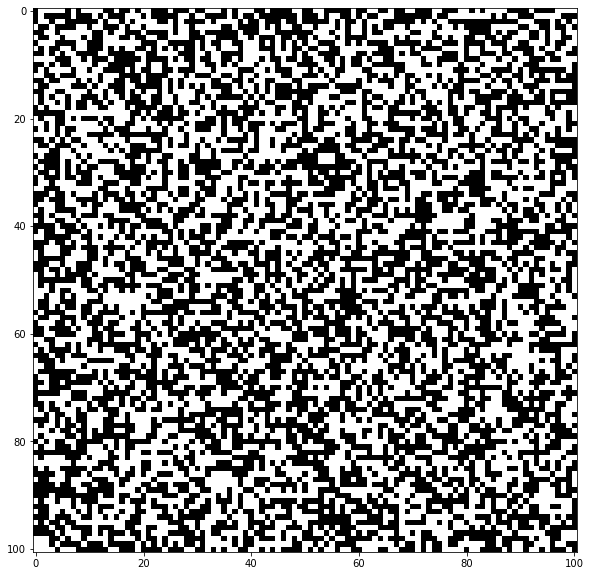

Magnetization =  0.0004901480247034605


In [3]:
# Randomly initialized Ising lattice
spins = fe.ising()
print('Magnetization = ', fe.magnetization(spins))

In [4]:
# Introduce defects in the lattice
Ndefects = 1000  # Try 10 and 1000 for a nice contrast of possibilities!
(Nx,Ny) = spins.shape
defect_map = ( np.zeros(spins.shape, dtype='uint8') == 1 ) # Array of all False
x = np.random.randint(0,Nx,size=(Ndefects))
y = np.random.randint(0,Ny,size=(Ndefects))
defect_map[x,y]=True
#spins[x,y]=0

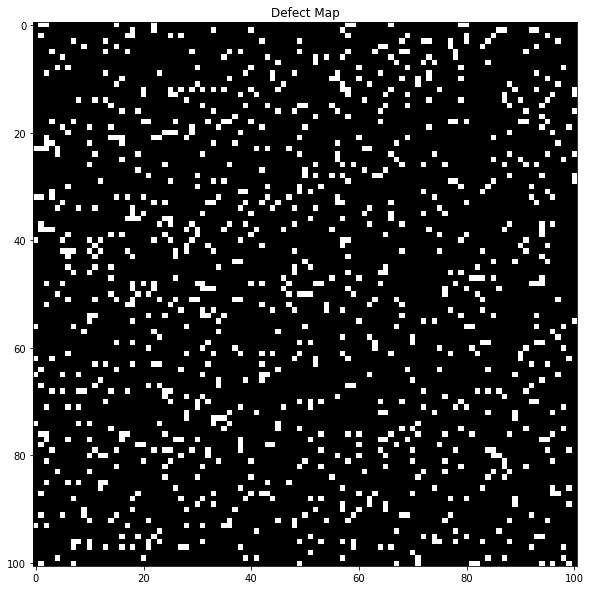

In [5]:
plt.figure(figsize=(15,10))
plt.imshow(defect_map,cmap='gray')
plt.title('Defect Map')
plt.show()

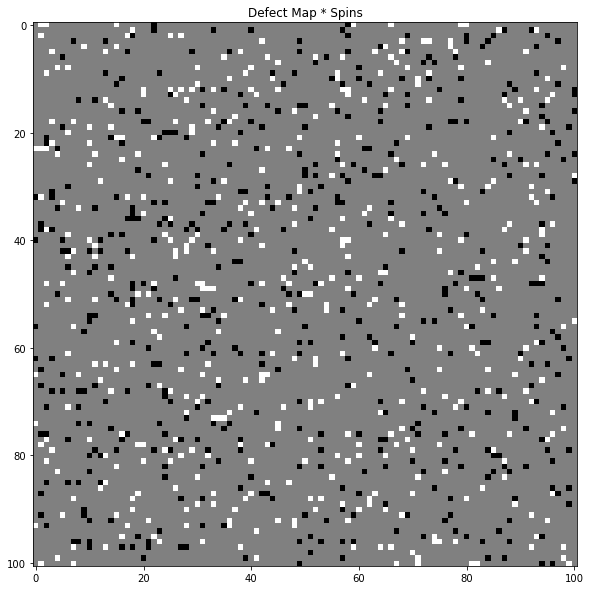

Mean magnetization of defects =  -0.042


In [6]:
plt.figure(figsize=(15,10))
plt.imshow(defect_map * spins,cmap='gray')
plt.title('Defect Map * Spins')
plt.show()
print('Mean magnetization of defects = ',np.sum(defect_map*spins)/Ndefects)

In [7]:
# Allow the model to evolve
kTamb = 0.5  # Ambient temperature
Bapplied = 0.0
Nwait = 2000

M = fe.many_smart_iterations(spins, Bapplied, kTamb, Nwait, defects=defect_map)

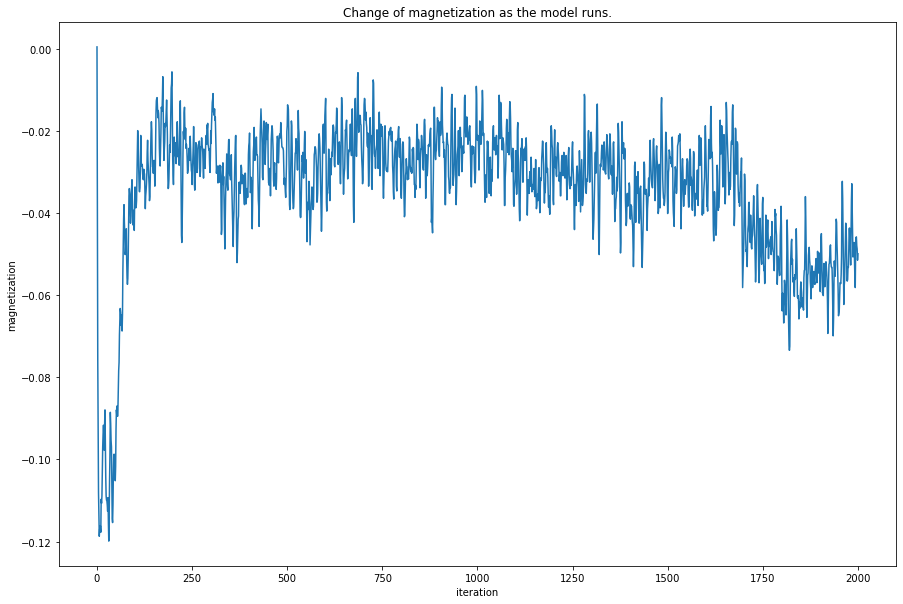

In [8]:
# Did the magnetization change?
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('iteration')
plt.ylabel('magnetization')
plt.title('Change of magnetization as the model runs.')
plt.show()

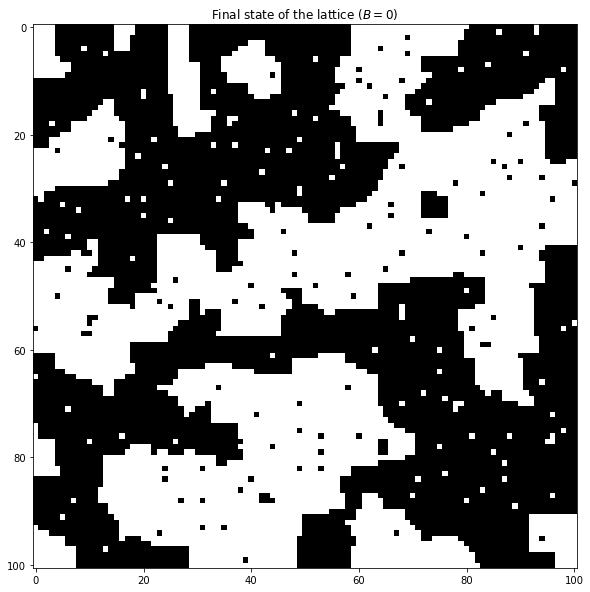

Final magnetization =  -0.04989706891481227


In [9]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Final state of the lattice ($B=0$)')
plt.show()
print('Final magnetization = ', fe.magnetization(spins))

In [10]:
# Magnetize
Bmax = 2.0
Nwait = 20

M = fe.many_smart_iterations(spins, Bmax, kTamb, Nwait, defects=defect_map)

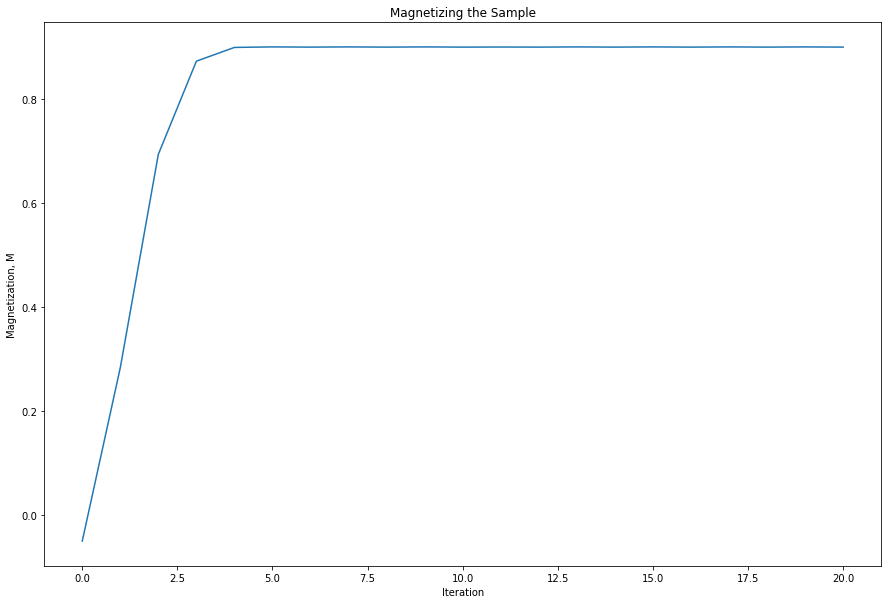

In [11]:
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('Iteration')
plt.ylabel('Magnetization, M')
plt.title('Magnetizing the Sample')
plt.show()

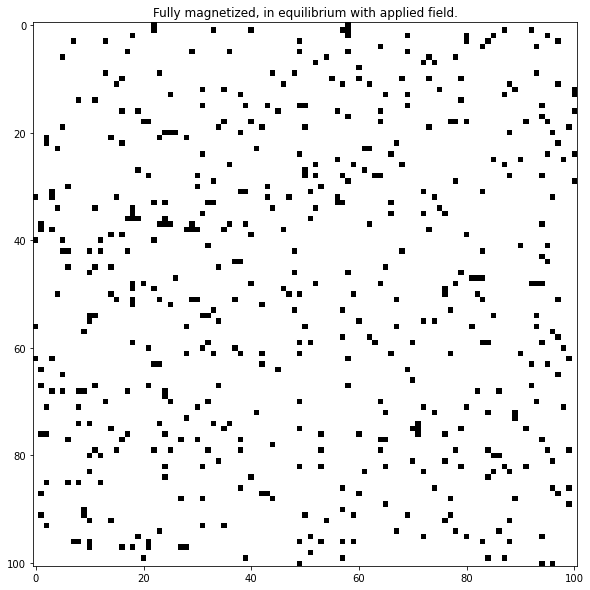

Final magnetization =  0.9005979805901382


In [12]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Fully magnetized, in equilibrium with applied field.')
plt.show()
print('Final magnetization = ', M[-1])

In [13]:
# Does it remain magnetized?
Bapplied = 0.0
Nwait = 2000

M = fe.many_smart_iterations(spins, Bapplied, kTamb, Nwait, defects=defect_map)

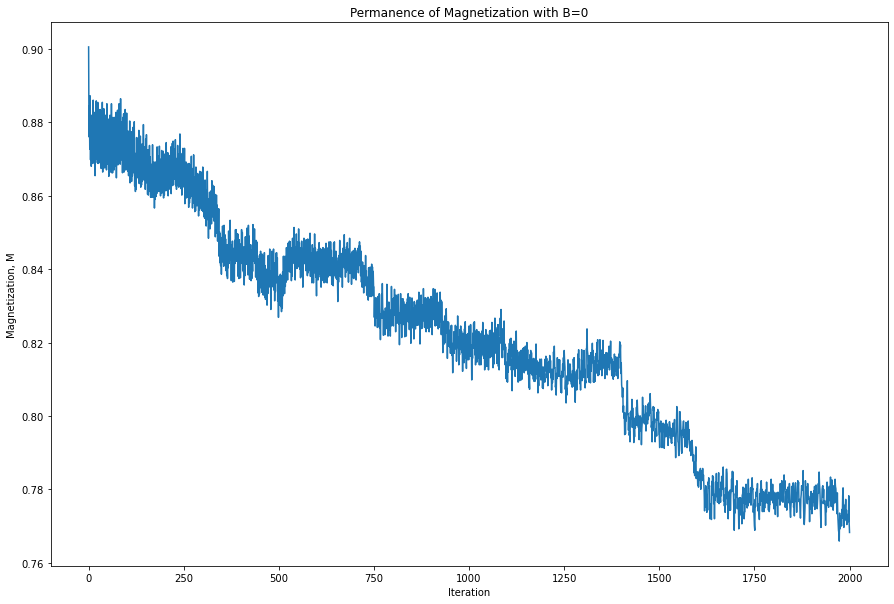

In [14]:
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('Iteration')
plt.ylabel('Magnetization, M')
plt.title('Permanence of Magnetization with B=0')
plt.show()

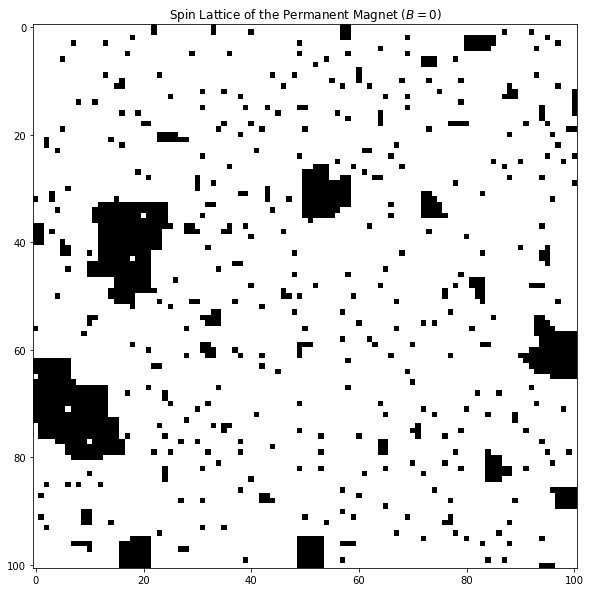

Final magnetization =  0.7682580139202039


In [15]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Spin Lattice of the Permanent Magnet ($B=0$)')
plt.show()
print('Final magnetization = ', M[-1])

In [16]:
# Many runs from the magnetized state, at different temperatures
Nsteps = 100
kTmax = 5.0
kTramp = np.arange(1,Nsteps+1)*kTmax/Nsteps
Bapplied = 0.0
Mheating = np.empty((Nsteps))
for i in range(Nsteps):
    spins_copy = spins.copy() # For each kT step, start from the same initial condition.
    fe.many_smart_iterations(spins_copy, Bapplied, kTramp[i], 20, defects=defect_map)
    Mheating[i] = fe.magnetization(spins_copy)
    

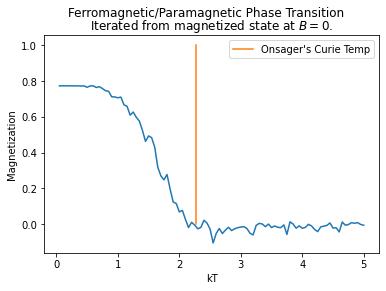

Note that Onsager's analytic calculation did not include defects.


In [17]:
plt.plot(kTramp, Mheating)
plt.plot( np.array((2.269,2.269)), np.array((0,1)), label="Onsager's Curie Temp" )
plt.xlabel('kT')
plt.ylabel('Magnetization')
plt.suptitle('Ferromagnetic/Paramagnetic Phase Transition')
plt.title('Iterated from magnetized state at $B=0$.')
plt.legend()
plt.show()
print("Note that Onsager's analytic calculation did not include defects.")

In [18]:
# Hysteresis Curve at High Temperature
spins = spins_copy.copy() # Start out demagnetized.
Nsteps = 400
Bhot = np.empty((Nsteps))
Mhot = np.empty((Nsteps))
for i in range(Nsteps):
    Bhot[i] = Bmax * np.sin(3*np.pi*i/Nsteps)
    fe.many_smart_iterations(spins, Bhot[i], kTmax, 50, defects=defect_map)
    Mhot[i] = fe.magnetization(spins)

In [19]:
# Hysteresis Curve at Ambient Temperature
spins = spins_copy.copy() # Start out demagnetized.
Nsteps = 400
B = np.empty((Nsteps))
M = np.empty((Nsteps))
for i in range(Nsteps):
    B[i] = Bmax * np.sin(3*np.pi*i/Nsteps)
    fe.many_smart_iterations(spins, B[i], kTamb, 50, defects=defect_map)
    M[i] = fe.magnetization(spins)

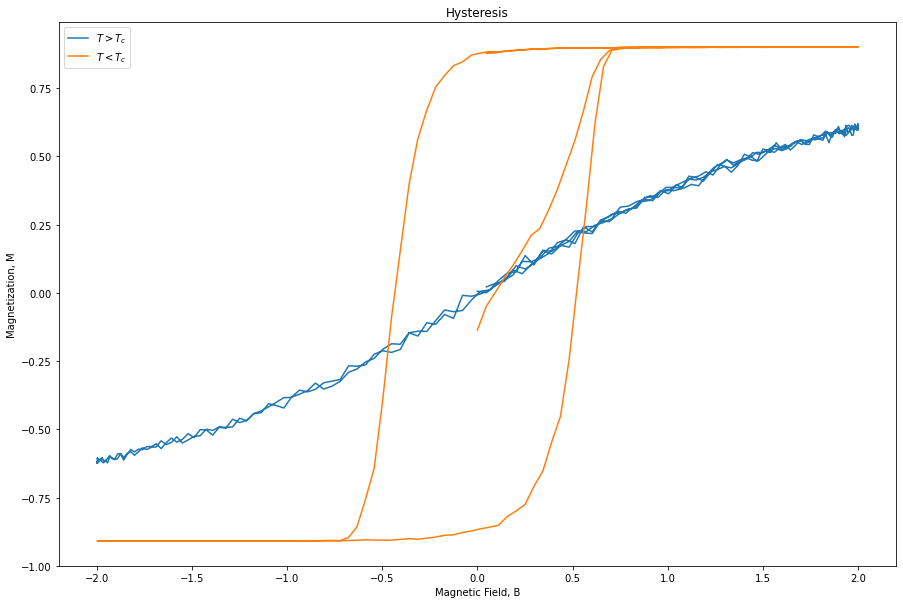

In [20]:
plt.figure(figsize=(15,10))
plt.plot(Bhot, Mhot, label='$T>T_c$')
plt.plot(B, M,       label='$T<T_c$')
plt.xlabel('Magnetic Field, B')
plt.ylabel('Magnetization, M')
plt.title('Hysteresis')
plt.legend()
plt.show()

In [21]:
# Demagnetize
Nsteps = 1000
period = 20
decaytime = 10*period
B = np.empty((Nsteps))
M = np.empty((Nsteps))
for i in range(Nsteps):
    B[i] = Bmax * np.exp(-i/decaytime) * np.sin(2*np.pi*i/period)
    fe.many_smart_iterations(spins, B[i], kTamb, 20, defects=defect_map)
    M[i] = fe.magnetization(spins)

Text(0.5, 0, 'Time (arbitrary units)')

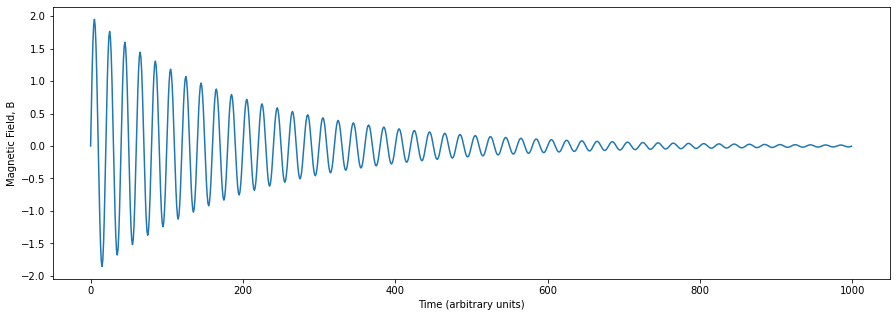

In [22]:
plt.figure(figsize=(15,5))
plt.plot(B)
plt.ylabel('Magnetic Field, B')
plt.xlabel('Time (arbitrary units)')

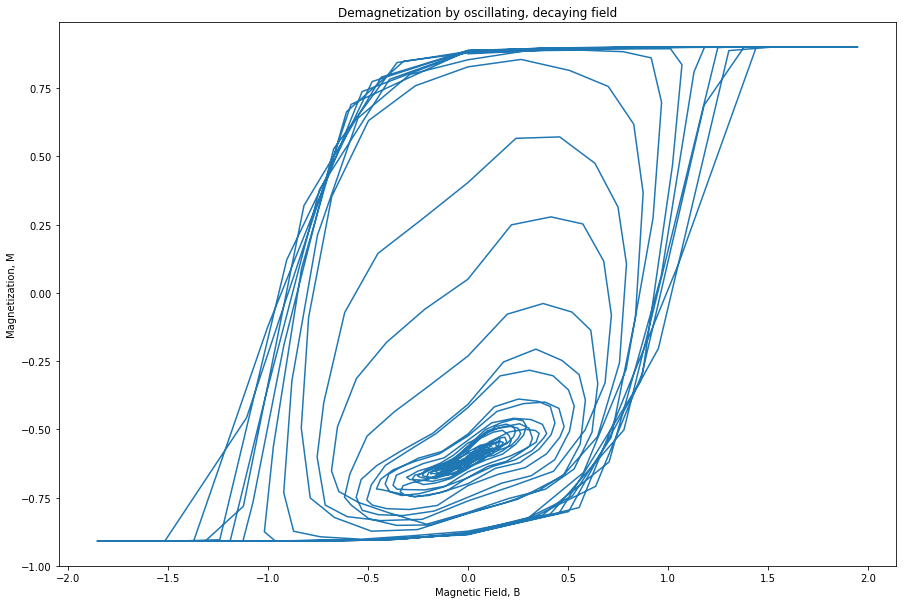

In [23]:
plt.figure(figsize=(15,10))
plt.plot(B,M)
plt.xlabel('Magnetic Field, B')
plt.ylabel('Magnetization, M')
plt.title('Demagnetization by oscillating, decaying field')
plt.show()

Text(0.5, 0, 'Time (arbitrary units)')

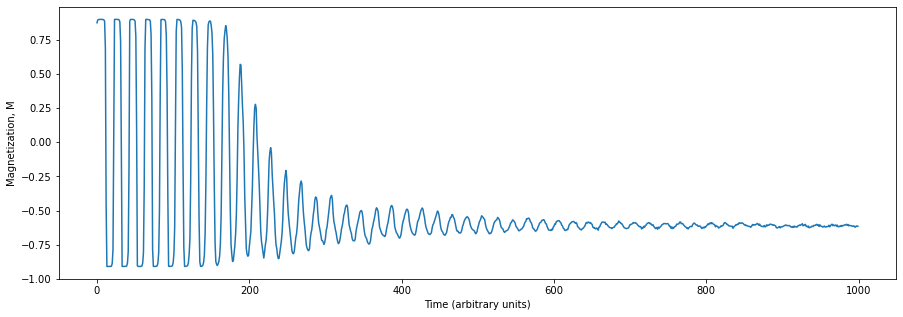

In [24]:
plt.figure(figsize=(15,5))
plt.plot(M)
plt.ylabel('Magnetization, M')
plt.xlabel('Time (arbitrary units)')

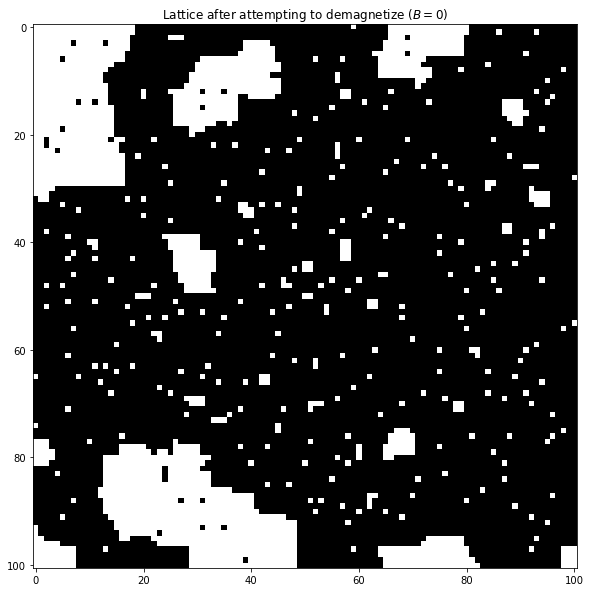

Final magnetization =  -0.6151357710028429


In [25]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Lattice after attempting to demagnetize ($B=0$)')
plt.show()
print('Final magnetization = ', fe.magnetization(spins))

In [26]:
# Re-Magnetize
Bmax = 2.0
Nwait = 20

M = fe.many_smart_iterations(spins, Bmax, kTamb, Nwait, defects=defect_map)

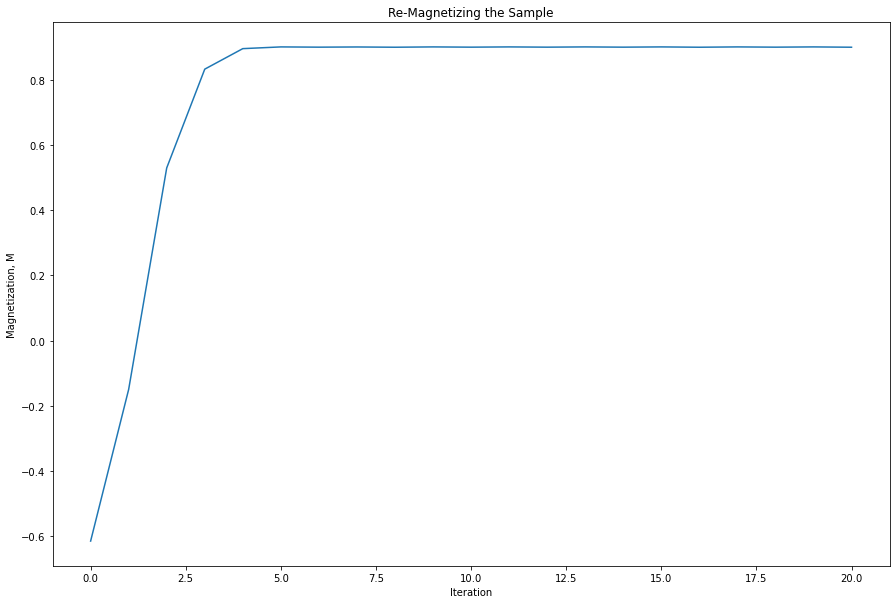

In [27]:
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('Iteration')
plt.ylabel('Magnetization, M')
plt.title('Re-Magnetizing the Sample')
plt.show()

In [28]:
# Demagnetize by heating
kT_hot = 2.5
Bapplied= -0.05
M = fe.many_smart_iterations(spins, Bapplied, kT_hot, 200, defects=defect_map)
spins_randomized = spins.copy() # save for future reference

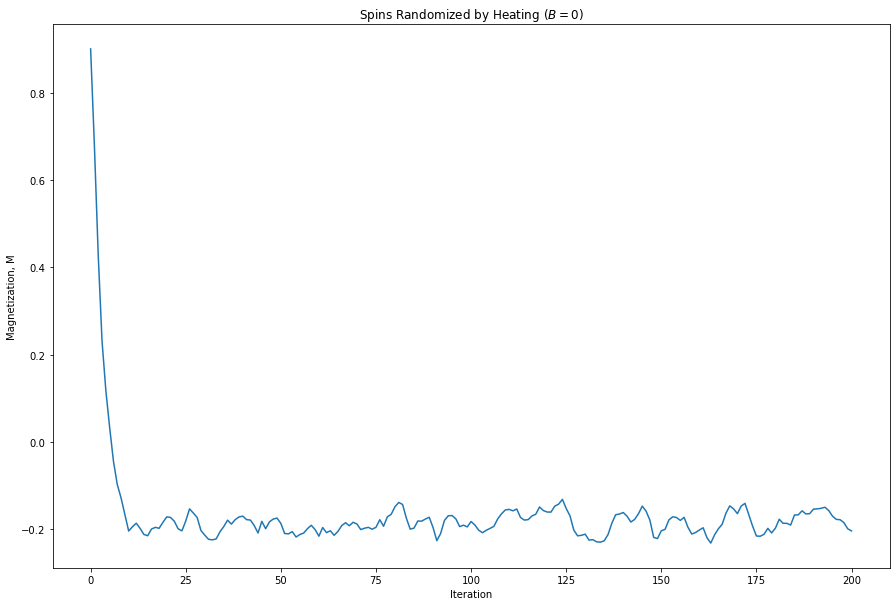

In [29]:
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('Iteration')
plt.ylabel('Magnetization, M')
plt.title('Spins Randomized by Heating ($B=0$)')
plt.show()

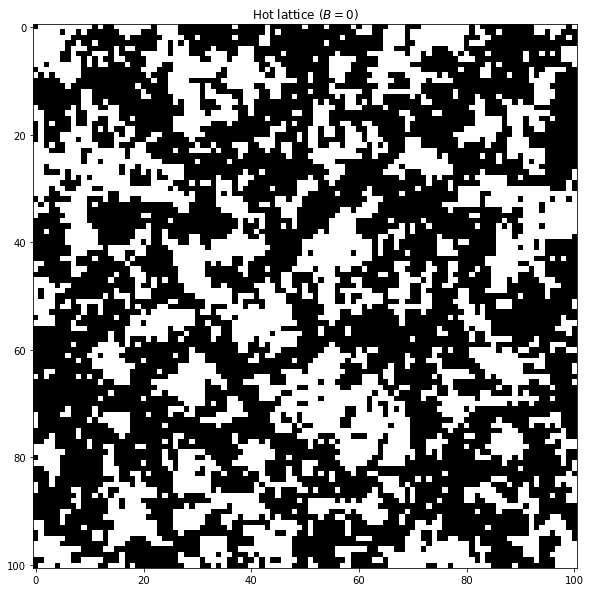

Magnetization =  -0.20399960788158022


In [30]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Hot lattice ($B=0$)')
plt.show()
print('Magnetization = ', fe.magnetization(spins))

In [ ]:
# Cool gradually, see what happens to magnetization.
spins = spins_randomized.copy()  # Start out with spins randomized by heating.
deltaT = 0.99*kT_hot
Ncool = 5000
kT_range = kT_hot - deltaT * np.arange(Ncool)/Ncool
Bapplied=0.0
M = np.empty((Ncool))
for i in range(Ncool):
    fe.smart_iterate(spins, Bapplied, kT_range[i], defects=defect_map)
    M[i] = fe.magnetization(spins)

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('Iteration')
plt.ylabel('Magnetization, M')
plt.title('Gradual Cooling (Annealing)')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Lattice state ($B=0, kT = 0$), after annealing')
plt.show()
print('Final magnetization = ', fe.magnetization(spins))

In [ ]:
# Quench
kT_cool = 0.01
spins = spins_randomized.copy()  # Start out with spins randomized by heating.

M = fe.many_smart_iterations(spins, Bapplied, kT_range[i], 5000, defects=defect_map)


In [ ]:
plt.figure(figsize=(15,10))
plt.plot(M)
plt.xlabel('Iteration')
plt.ylabel('Magnetization, M')
plt.title('Rapid Cooling (Quenching)')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(spins,cmap='gray')
plt.title('Lattice state ($B=0, kT=0$), after quenching')
plt.show()
print('Final magnetization = ', fe.magnetization(spins))